In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat_trainmode import load_generator_network
from definitions.predictor.aparent import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

#Plot joint histograms
def plot_joint_histo(measurements, labels, x_label, y_label, colors=None, n_bins=50, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=150, min_val=None, max_val=None, max_y_val=None) :
    
    min_hist_val = np.min(measurements[0])
    max_hist_val = np.max(measurements[0])
    for i in range(1, len(measurements)) :
        min_hist_val = min(min_hist_val, np.min(measurements[i]))
        max_hist_val = max(max_hist_val, np.max(measurements[i]))
    
    if min_val is not None :
        min_hist_val = min_val
    if max_val is not None :
        max_hist_val = max_val

    hists = []
    bin_edges = []
    means = []
    for i in range(len(measurements)) :
        hist, b_edges = np.histogram(measurements[i], range=(min_hist_val, max_hist_val), bins=n_bins, density=True)
        
        hists.append(hist)
        bin_edges.append(b_edges)
        means.append(np.mean(measurements[i]))
    
    bin_width = bin_edges[0][1] - bin_edges[0][0]


    f = plt.figure(figsize=figsize)

    for i in range(len(measurements)) :
        if colors is not None :
            plt.bar(bin_edges[i][1:] - bin_width/2., hists[i], width=bin_width, linewidth=2, edgecolor='black', color=colors[i], label=labels[i])
        else :
            plt.bar(bin_edges[i][1:] - bin_width/2., hists[i], width=bin_width, linewidth=2, edgecolor='black', label=labels[i])
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlim(min_hist_val, max_hist_val)
    if max_y_val is not None :
        plt.ylim(0, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    if colors is not None :
        for i in range(len(measurements)) :
            plt.axvline(x=means[i], linewidth=2, color=colors[i], linestyle="--")

    if not legend_outside :
        plt.legend(fontsize=14, loc='upper left')
    else :
        plt.legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()

#Plot join histograms
def plot_joint_cmp(measurements, labels, y_label, plot_type='violin', colors=None, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=150, min_y_val=None, max_y_val=None, violin_bw=None, violin_cut=None) :
    
    f = plt.figure(figsize=figsize)

    sns_g = None
    if colors is not None :
        if plot_type == 'violin' :
            if violin_bw is None :
                if violin_cut is None :
                    sns_g = sns.violinplot(data=measurements, palette=colors, scale='width')
                else :
                    sns_g = sns.violinplot(data=measurements, palette=colors, scale='width', cut=violin_cut)
            else :
                if violin_cut is None :
                    sns_g = sns.violinplot(data=measurements, palette=colors, scale='width', bw=violin_bw)
                else :
                    sns_g = sns.violinplot(data=measurements, palette=colors, scale='width', bw=violin_bw, cut=violin_cut)
        elif plot_type == 'strip' :
            sns_g = sns.stripplot(data=measurements, palette=colors, alpha=0.1, jitter=0.3, linewidth=2, edgecolor='black') #, x=labels
            for i in range(len(measurements)) :
                plt.plot(x=[i, i+1], y=[np.median(measurements[i]), np.median(measurements[i])], linewidth=2, color=colors[i], linestyle="--")
        elif plot_type == 'bar' :
            for i in range(len(measurements)) :
                plt.bar([i], [np.percentile(measurements[i], 100)], width=0.4, color=colors[i], label=str(i) + ") " + labels[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.2], [np.percentile(measurements[i], 95)], width=0.4, color=colors[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.4], [np.percentile(measurements[i], 80)], width=0.4, color=colors[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.6], [np.percentile(measurements[i], 50)], width=0.4, color=colors[i], linewidth=2, edgecolor='black')
    else :
        if plot_type == 'violin' :
            if violin_bw is None :
                if violin_cut is None :
                    sns_g = sns.violinplot(data=measurements, scale='width')
                else :
                    sns_g = sns.violinplot(data=measurements, scale='width', cut=violin_cut)
            else :
                if violin_cut is None :
                    sns_g = sns.violinplot(data=measurements, scale='width', bw=violin_bw)
                else :
                    sns_g = sns.violinplot(data=measurements, scale='width', bw=violin_bw, cut=violin_cut)
        elif plot_type == 'strip' :
            sns_g = sns.stripplot(data=measurements, alpha=0.1, jitter=0.3, linewidth=2, edgecolor='black') #, x=labels
        elif plot_type == 'bar' :
            for i in range(len(measurements)) :
                plt.bar([i], [np.percentile(measurements[i], 100)], width=0.25, label=str(i) + ") " + labels[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.125], [np.percentile(measurements[i], 95)], width=0.25, linewidth=2, edgecolor='black')
                plt.bar([i+0.25], [np.percentile(measurements[i], 80)], width=0.25, linewidth=2, edgecolor='black')
                plt.bar([i+0.375], [np.percentile(measurements[i], 50)], width=0.25, linewidth=2, edgecolor='black')
    
    plt.xticks(np.arange(len(labels)), fontsize=14)
    plt.yticks(fontsize=14)
    
    #plt.xlim(min_hist_val, max_hist_val)
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.ylabel(y_label, fontsize=14)
    
    if plot_type not in ['violin', 'strip'] :
        if not legend_outside :
            plt.legend(fontsize=14, loc='upper left')
        else :
            plt.legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    else :
        if not legend_outside :
            f.get_axes()[0].legend(fontsize=14, loc="upper left", labels=[str(label_i) + ") " + label for label_i, label in enumerate(labels)])
        else :
            f.get_axes()[0].legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left", labels=[str(label_i) + ") " + label for label_i, label in enumerate(labels)])
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()

#Load generated data from models to be evaluated

def load_sequences(file_path, split_on_tab=True, seq_template=None, max_n_sequences=1e6, select_best_fitness=False, predictor=None, batch_size=32) :
    seqs = []
    
    with open(file_path, "rt") as f :
        for l in f.readlines() :
            l_strip = l.strip()
            seq = l_strip
            if split_on_tab :
                seq = l_strip.split("\t")[0]
            
            if seq_template is not None :
                seq = ''.join([
                    seq_template[j] if seq_template[j] != 'N' else seq[j]
                    for j in range(len(seq))
                ])

            seqs.append(seq)
        
    if select_best_fitness and predictor is not None :
        fake_lib = np.zeros((len(seqs), 13))
        fake_lib[:, 5] = 1.
        fake_d = np.ones((len(seqs), 1))

        onehots = np.expand_dims(np.concatenate([
            np.expand_dims(acgt_encoder.encode(seq), axis=0) for seq in seqs
        ], axis=0), axis=-1)

        #Predict fitness
        prob_pred, _ = predictor.predict(x=[onehots, fake_lib, fake_d], batch_size=batch_size)
        prob_pred = np.ravel(prob_pred)
        
        sort_index = np.argsort(prob_pred)[::-1]
        seqs = [
            seqs[sort_index[i]] for i in range(len(seqs))
        ]
    
    return seqs[:max_n_sequences]

#Metric helper functions

def compute_latent_manhattan_distance(latent_vecs) :
    shuffle_index = np.arange(latent_vecs.shape[0])
    shuffle_index = shuffle_index[::-1]#np.random.shuffle(shuffle_index)

    latent_vecs_shuffled = latent_vecs[shuffle_index]
    latent_dists = np.sum(np.abs(latent_vecs - latent_vecs_shuffled), axis=-1)

    mean_latent_distance = np.mean(latent_dists)
    
    return latent_dists, mean_latent_distance

def compute_latent_cosine_distance(latent_vecs) :
    shuffle_index = np.arange(latent_vecs.shape[0])
    shuffle_index = shuffle_index[::-1]#np.random.shuffle(shuffle_index)

    latent_vecs_shuffled = latent_vecs[shuffle_index]
    latent_cosines = np.sum(latent_vecs * latent_vecs_shuffled, axis=-1) / (np.sqrt(np.sum(latent_vecs**2, axis=-1)) * np.sqrt(np.sum(latent_vecs_shuffled**2, axis=-1)))
    latent_cosines = 1. - latent_cosines
    
    mean_latent_cosine = np.mean(latent_cosines)
    
    return latent_cosines, mean_latent_cosine

def compute_edit_distance(onehots, opt_len=100) :
    shuffle_index = np.arange(onehots.shape[0])
    shuffle_index = shuffle_index[::-1]#np.random.shuffle(shuffle_index)
    
    seqs = [acgt_encoder.decode(onehots[i, :, :, 0]) for i in range(onehots.shape[0])]
    seqs_shuffled = [seqs[shuffle_index[i]] for i in range(onehots.shape[0])]
    edit_distances = np.ravel([float(editdistance.eval(seq_1, seq_2)) for seq_1, seq_2 in zip(seqs, seqs_shuffled)])
    edit_distances /= opt_len
    
    mean_edit_distance = np.mean(edit_distances)
    
    return edit_distances, mean_edit_distance

#Evaluate metrics for each model

def compute_metrics(seqs, n_seqs_to_test=960, batch_size=64, opt_len=90) :
    
    fake_lib = np.zeros((n_seqs_to_test, 13))
    fake_lib[:, 5] = 1.
    fake_d = np.ones((n_seqs_to_test, 1))
    
    onehots = np.expand_dims(np.concatenate([
        np.expand_dims(acgt_encoder.encode(seq), axis=0) for seq in seqs
    ], axis=0), axis=-1)

    vae_onehots = np.concatenate([
        one_hot_encode(vae_upstream_padding, n=n_seqs_to_test, singleton_axis=1),
        np.expand_dims(onehots[..., 0], axis=1),
        one_hot_encode(vae_downstream_padding, n=n_seqs_to_test, singleton_axis=1)
    ], axis=2)

    #Get sequence VAE encodings for test data
    z_mean, z_log_var, z = vae_encoder_model.predict(x=vae_onehots, batch_size=batch_size, verbose=False)

    #Predict fitness
    prob_pred, _, dense_pred = saved_predictor_w_dense.predict(x=[onehots[:n_seqs_to_test], fake_lib, fake_d], batch_size=batch_size)
    prob_pred = np.ravel(prob_pred)
    score_pred = np.log(prob_pred / (1. - prob_pred))
    
    #Compare pair-wise latent distances
    z_mean_latent_dists, _ = compute_latent_manhattan_distance(z_mean)
    dense_dists, _ = compute_latent_manhattan_distance(dense_pred)

    #Compare pair-wise latent cosine similarities
    z_mean_latent_cosines, _ = compute_latent_cosine_distance(z_mean)
    dense_cosines, _ = compute_latent_cosine_distance(dense_pred)
    
    #Compare pair-wise edit distances
    edit_dists, _ = compute_edit_distance(onehots[:n_seqs_to_test], opt_len=opt_len)
    
    return score_pred, dense_dists, dense_cosines, z_mean_latent_dists, z_mean_latent_cosines, edit_dists

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Maximize isoform proportions for all native minigene libraries

sequence_template = 'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'

problem_prefix = "apa_genesis_max_isoform_simple"

n_seqs_to_test = 4000


In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
saved_predictor_model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

saved_predictor = load_model(saved_predictor_model_path)

acgt_encoder = IdentityEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
#Get latent space predictor
saved_predictor_w_dense = Model(
    inputs = saved_predictor.inputs,
    outputs = saved_predictor.outputs + [saved_predictor.get_layer('dropout_1').output]
)
saved_predictor_w_dense.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))


In [5]:
#Load cached dataframe of measured APA data
cached_dict = pickle.load(open('apa_simple_cached_set.pickle', 'rb'))
plasmid_df = cached_dict['plasmid_df']
plasmid_cuts = cached_dict['plasmid_cuts']

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (loaded)")

#Make generators

valid_set_size = 0.005#0.05
test_set_size = 0.095#0.05

batch_size = 32

#Generate training and test set indexes
plasmid_index = np.arange(len(plasmid_df), dtype=np.int)

plasmid_train_index = plasmid_index[:-int(len(plasmid_df) * (valid_set_size + test_set_size))]
plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_df) * test_set_size)]
plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

print('Training set size = ' + str(plasmid_train_index.shape[0]))
print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
print('Test set size = ' + str(plasmid_test_index.shape[0]))


data_gens = {
    gen_id : isol.DataGenerator(
        idx,
        {'df' : plasmid_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : isol.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : isol.OneHotEncoder(seq_length=205),
                'dim' : (205, 4, 1),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'dummy_output',
                'source_type' : 'zeros',
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False
    ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
}

onehots_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
onehots_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)

print(onehots_train.shape)
print(onehots_test.shape)


len(plasmid_df) = 49901 (loaded)
Training set size = 44911
Validation set size = 250
Test set size = 4740
(44896, 205, 4, 1)
(4736, 205, 4, 1)


In [6]:
#VAE model path
saved_vae_encoder_model_path = 'vae/saved_models/vae_apa_max_isoform_simple_new_resnet_len_256_50_epochs_medium_high_kl_encoder.h5'
saved_vae_decoder_model_path = 'vae/saved_models/vae_apa_max_isoform_simple_new_resnet_len_256_50_epochs_medium_high_kl_decoder.h5'

#Padding for the VAE
vae_upstream_padding = 'GGCGGCATGGACGAGCTGTACAAGTCTTGA'
vae_downstream_padding = 'TCGGTCAAGCCTTGCCTTGTT'

#VAE sequence template
vae_sequence_template = 'GGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGTCGGTCAAGCCTTGCCTTGTT'

#VAE latent dim
vae_latent_dim = 100

def min_pred(y_true, y_pred) :
    return y_pred

#One-hot encode sequences
def one_hot_encode(seq, n=1, singleton_axis=-1) :

    one_hots = None
    if singleton_axis == 1 :
        one_hots = np.zeros((n, 1, len(seq), 4))
        for j in range(len(seq)) :
            if seq[j] == 'A' :
                one_hots[:, 0, j, 0] = 1.
            elif seq[j] == 'C' :
                one_hots[:, 0, j, 1] = 1.
            elif seq[j] == 'G' :
                one_hots[:, 0, j, 2] = 1.
            elif seq[j] == 'T' :
                one_hots[:, 0, j, 3] = 1.
    else :
        one_hots = np.zeros((n, len(seq), 4, 1))
        for j in range(len(seq)) :
            if seq[j] == 'A' :
                one_hots[:, j, 0, 0] = 1.
            elif seq[j] == 'C' :
                one_hots[:, j, 1, 0] = 1.
            elif seq[j] == 'G' :
                one_hots[:, j, 2, 0] = 1.
            elif seq[j] == 'T' :
                one_hots[:, j, 3, 0] = 1.
    
    return one_hots

#Load VAE models
vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred})


In [7]:
#Build test data
test_sequences = [
    acgt_encoder.decode(onehots_test[i, :, :, 0])
    for i in range(n_seqs_to_test)
]

#Build random data
random_sequences = [
    ''.join([
        sequence_template[j] if sequence_template[j] != 'N' else np.random.choice(['A', 'C', 'G', 'T'])
        for j in range(len(sequence_template))
    ]) for i in range(n_seqs_to_test)
]

In [9]:
#Load generated data from models to be evaluated

model_sequence_files = [
    "../../../fbgan/apa_simple_sample_iter_None_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/apa_simple_sample_iter_None_4094_sequences_sampling_factor_10.txt",
    "../../../fbgan/apa_simple_strong_iter_None_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/apa_simple_strong_iter_None_4094_sequences_sampling_factor_10.txt",
    
    "../../../fbgan/fbgan_apa_simple_sample_iter_50_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/fbgan_apa_simple_sample_iter_100_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/fbgan_apa_simple_sample_iter_None_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/fbgan_apa_simple_sample_median_cutoff_iter_50_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/fbgan_apa_simple_sample_median_cutoff_iter_100_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/fbgan_apa_simple_sample_median_cutoff_iter_None_4094_sequences_sampling_factor_1.txt",
    
    "../../../fbgan/killoran_apa_4096_sequences_1000_iters.txt",
    
    "../../../seqprop/examples/apa/seqprop_apa_max_isoform_simple_single_pwm_50000_updates_4096_sequences.txt",
    
    "../../../seqprop/examples/apa/seqprop_apa_max_isoform_simple_multi_pwm_50000_updates_4096_sequences.txt",
    
    "basinhopping_apa_max_isoform_simple_1000_iters_4096_sequences.txt",
    
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_05_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_03_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_seq_05_lat_07_latent_penalty_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_seq_03_lat_07_latent_penalty_4096_sequences.txt",
    
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_095_weight_005_trainmode_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_095_trainmode_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_09_trainmode_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_07_trainmode_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_06_trainmode_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_055_trainmode_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_05_trainmode_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_045_trainmode_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_04_trainmode_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_03_trainmode_4096_sequences.txt",
    
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_06_retry_2_4096_sequences.txt",
    "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_seq_06_lat_07_latent_penalty_retry_2_4096_sequences.txt"
]

model_names = [
    "GAN (unif data, 1x sampling)",
    "GAN (unif data, 10x sampling)",
    "GAN (>0.95 data, 1x sampling)",
    "GAN (>0.95 data, 10x sampling)",
    
    "FBGAN (thr = .8, 50 ep)",
    "FBGAN (thr = .8, 100 ep)",
    "FBGAN (thr = .8, 150 ep)",
    "FBGAN (thr = median, 50 ep)",
    "FBGAN (thr = median, 100 ep)",
    "FBGAN (thr = median, 150 ep)",
    
    "Killoran (1000 iters)",
    
    "Gradient Ascent (Single PWM)",
    "Gradient Ascent (Multi PWM)",
    "Simulated Annealing (1000 iters)",
    
    "DEN (seq margin 0.5)",
    "DEN (seq margin 0.3)",
    "DEN (seq/lat margin 0.5/0.7)",
    "DEN (seq/lat margin 0.3/0.7)",
    
    "DEN (no penalty)",
    
    "DEN (seq margin 0.95)",
    "DEN (seq margin 0.9)",
    "DEN (seq margin 0.7)",
    "DEN (seq margin 0.6)",
    "DEN (seq margin 0.55)",
    "DEN (seq margin 0.5)",
    "DEN (seq margin 0.45)",
    "DEN (seq margin 0.4)",
    "DEN (seq margin 0.3)",
    
    "DEN (seq margin 0.6)",
    "DEN (seq/lat margin 0.6/0.7)"
]

model_sequences = [
    load_sequences(model_sequence_file,
                   split_on_tab=True,
                   seq_template=sequence_template,
                   max_n_sequences=n_seqs_to_test,
                   select_best_fitness=True,
                   predictor=saved_predictor
                  )
    for model_sequence_file in model_sequence_files
]

model_names = [
    "Random"
] + model_names

model_sequences = [
    random_sequences
] + model_sequences

model_opt_lens = [
    90
] * len(model_sequences)


In [10]:
#Compute all metrics for all models

model_metrics = [
    compute_metrics(seqs, n_seqs_to_test=n_seqs_to_test, batch_size=64, opt_len=opt_l)
    for seqs, opt_l in zip(model_sequences, model_opt_lens)
]

fitness_scores, dense_distances, dense_cosines, vae_z_distances, vae_z_cosines, edit_distances = zip(*model_metrics)

fitness_scores = list(fitness_scores)
dense_distances = list(dense_distances)
dense_cosines = list(dense_cosines)
vae_z_distances = list(vae_z_distances)
vae_z_cosines = list(vae_z_cosines)
edit_distances = list(edit_distances)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


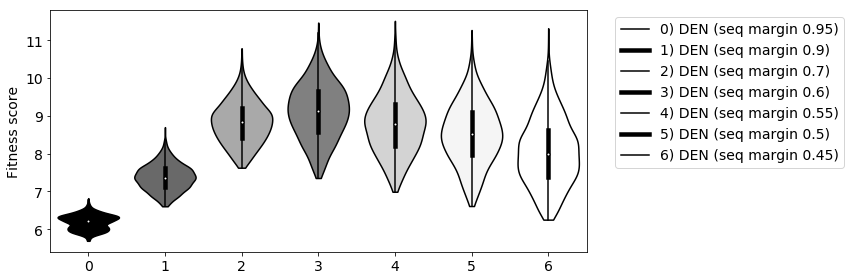

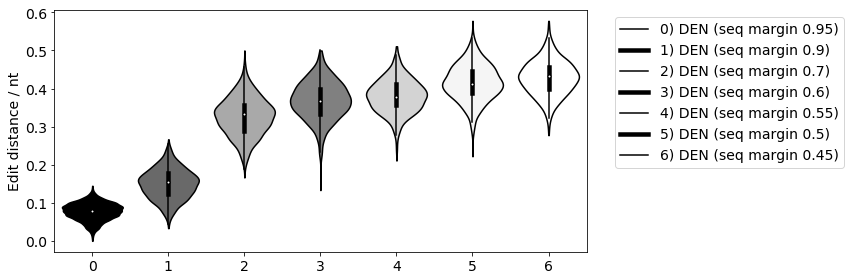

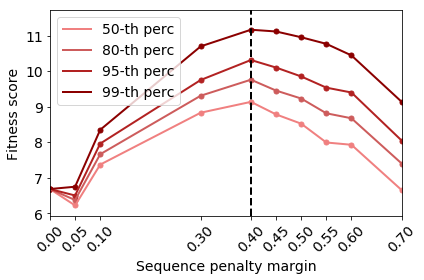

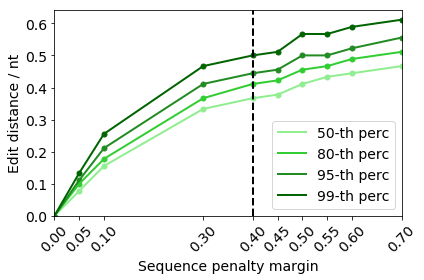

In [14]:
#DEN analysis and comparisons

experiment_suffix = "_den_diversity_parameter_kl_loss"

start_ix = 20
end_ix = 27

model_colors = ['white', 'whitesmoke', 'lightgrey', 'grey', 'darkgrey', 'dimgrey', 'black'][::-1]

violin_bw = 0.25#None
violin_cut = 0.0

plot_joint_cmp(
    fitness_scores[start_ix: end_ix],
    model_names[start_ix: end_ix],
    'Fitness score',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_violin",
    legend_outside=True,
    violin_bw=violin_bw,
    violin_cut=violin_cut
)

plot_joint_cmp(
    edit_distances[start_ix: end_ix],
    model_names[start_ix: end_ix],
    'Edit distance / nt',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_edit_distance_violin",
    legend_outside=True,
    violin_bw=violin_bw,
    violin_cut=violin_cut
)

save_figs = True

start_ix = 19
end_ix = 29

f = plt.figure(figsize=(6, 4))

x_margins = [
    1.0,
    0.95,
    0.9,
    0.7,
    0.6,
    0.55,
    0.5,
    0.45,
    0.4,
    0.3
]

x_margins = 1.0 - np.array(x_margins)

fitness_scores_perc_50 = [
    np.percentile(fitness_scores[i], 50) for i in range(start_ix, end_ix)
]

fitness_scores_perc_80 = [
    np.percentile(fitness_scores[i], 80) for i in range(start_ix, end_ix)
]

fitness_scores_perc_95 = [
    np.percentile(fitness_scores[i], 95) for i in range(start_ix, end_ix)
]

fitness_scores_perc_99 = [
    np.percentile(fitness_scores[i], 99.9) for i in range(start_ix, end_ix)
]

l1 = plt.plot(x_margins, fitness_scores_perc_50, color='lightcoral', linewidth=2, label='50-th perc')
l2 = plt.plot(x_margins, fitness_scores_perc_80, color='indianred', linewidth=2, label='80-th perc')
l3 = plt.plot(x_margins, fitness_scores_perc_95, color='firebrick', linewidth=2, label='95-th perc')
l4 = plt.plot(x_margins, fitness_scores_perc_99, color='darkred', linewidth=2, label='99-th perc')

plt.scatter(x_margins, fitness_scores_perc_50, s=25, color='lightcoral')
plt.scatter(x_margins, fitness_scores_perc_80, s=25, color='indianred')
plt.scatter(x_margins, fitness_scores_perc_95, s=25, color='firebrick')
plt.scatter(x_margins, fitness_scores_perc_99, s=25, color='darkred')

plt.plot([0.4, 0.4], [np.min(fitness_scores_perc_50) / 1.05, np.max(fitness_scores_perc_99) * 1.05], linewidth=2, linestyle='--', color='black')

plt.xlim(0.0, 0.7)
plt.ylim(np.min(fitness_scores_perc_50) / 1.05, np.max(fitness_scores_perc_99) * 1.05)

plt.xticks(x_margins, fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlabel("Sequence penalty margin", fontsize=14)
plt.ylabel("Fitness score", fontsize=14)

plt.legend(handles=[l1[0], l2[0], l3[0], l4[0]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(problem_prefix + experiment_suffix + "_fitness_score_sweep_curve.png", dpi=150, transparent=True)
    plt.savefig(problem_prefix + experiment_suffix + "_fitness_score_sweep_curve.svg")
    plt.savefig(problem_prefix + experiment_suffix + "_fitness_score_sweep_curve.eps")

plt.show()

f = plt.figure(figsize=(6, 4))

edit_distances_perc_50 = [
    np.percentile(edit_distances[i], 50) for i in range(start_ix, end_ix)
]

edit_distances_perc_80 = [
    np.percentile(edit_distances[i], 80) for i in range(start_ix, end_ix)
]

edit_distances_perc_95 = [
    np.percentile(edit_distances[i], 95) for i in range(start_ix, end_ix)
]

edit_distances_perc_99 = [
    np.percentile(edit_distances[i], 99.9) for i in range(start_ix, end_ix)
]

l1 = plt.plot(x_margins, edit_distances_perc_50, color='lightgreen', linewidth=2, label='50-th perc')
l2 = plt.plot(x_margins, edit_distances_perc_80, color='limegreen', linewidth=2, label='80-th perc')
l3 = plt.plot(x_margins, edit_distances_perc_95, color='forestgreen', linewidth=2, label='95-th perc')
l4 = plt.plot(x_margins, edit_distances_perc_99, color='darkgreen', linewidth=2, label='99-th perc')

plt.scatter(x_margins, edit_distances_perc_50, s=25, color='lightgreen')
plt.scatter(x_margins, edit_distances_perc_80, s=25, color='limegreen')
plt.scatter(x_margins, edit_distances_perc_95, s=25, color='forestgreen')
plt.scatter(x_margins, edit_distances_perc_99, s=25, color='darkgreen')

plt.plot([0.4, 0.4], [0, np.max(edit_distances_perc_99) * 1.05], linewidth=2, linestyle='--', color='black')

plt.xlim(0.0, 0.7)
plt.ylim(0.0, np.max(edit_distances_perc_99) * 1.05)

plt.xticks(x_margins, fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlabel("Sequence penalty margin", fontsize=14)
plt.ylabel("Edit distance / nt", fontsize=14)

plt.legend(handles=[l1[0], l2[0], l3[0], l4[0]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(problem_prefix + experiment_suffix + "_edit_distance_sweep_curve.png", dpi=150, transparent=True)
    plt.savefig(problem_prefix + experiment_suffix + "_edit_distance_sweep_curve.svg")
    plt.savefig(problem_prefix + experiment_suffix + "_edit_distance_sweep_curve.eps")

plt.show()


Evaluating on DEN (no penalty).


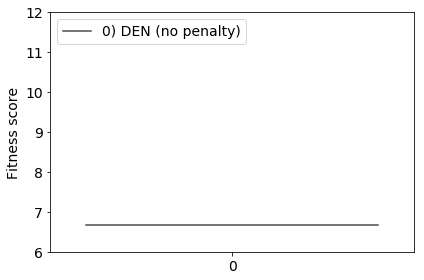

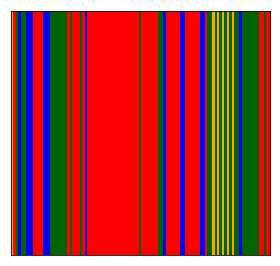

Evaluating on DEN (seq margin 0.95).


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


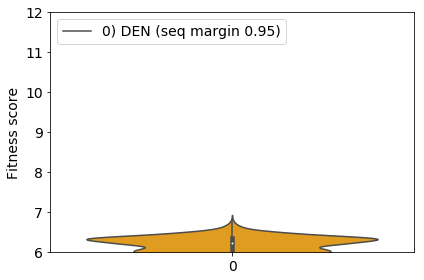

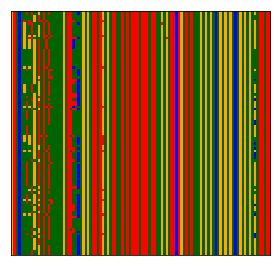

Evaluating on DEN (seq margin 0.9).


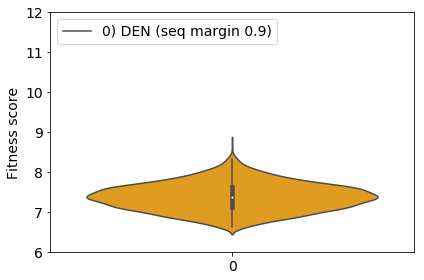

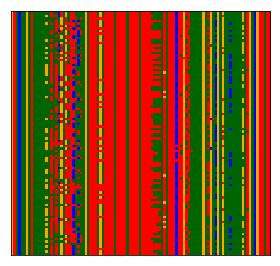

Evaluating on DEN (seq margin 0.7).


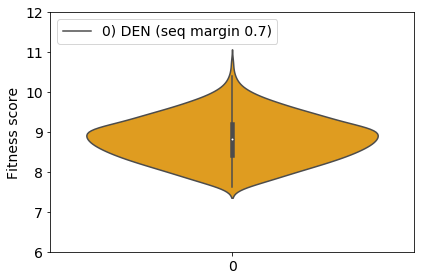

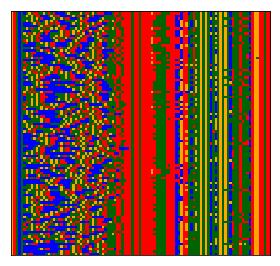

Evaluating on DEN (seq margin 0.6).


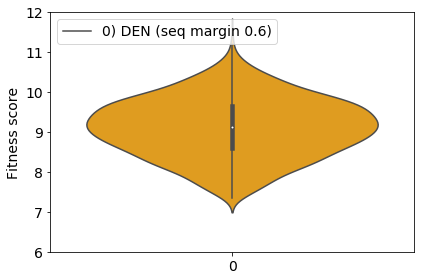

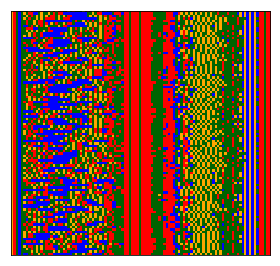

Evaluating on DEN (seq margin 0.55).


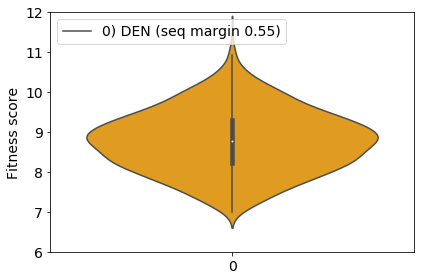

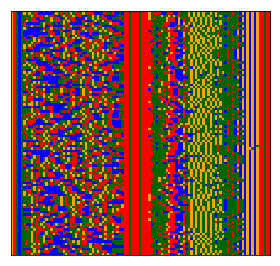

Evaluating on DEN (seq margin 0.5).


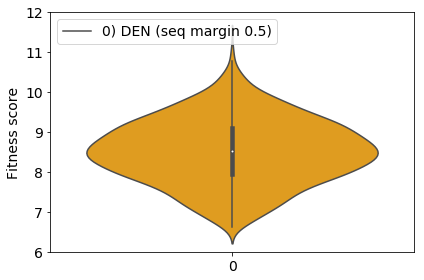

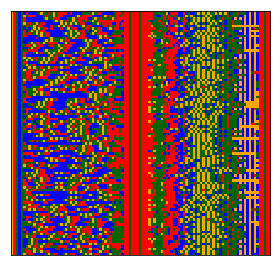

Evaluating on DEN (seq margin 0.45).


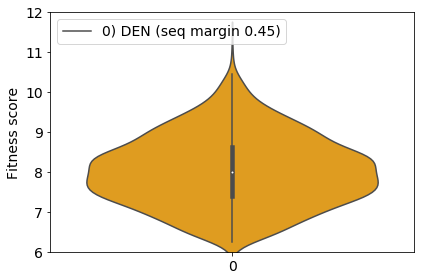

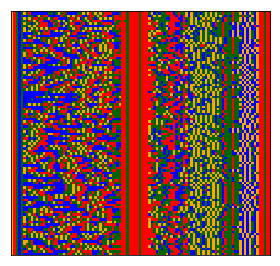

Evaluating on DEN (seq margin 0.4).


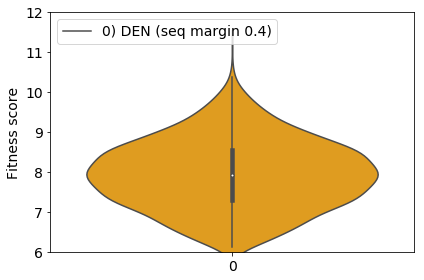

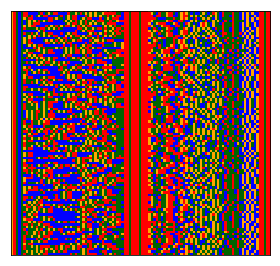

Evaluating on DEN (seq margin 0.3).


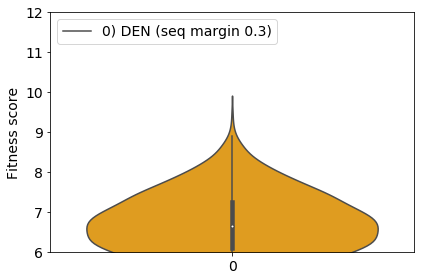

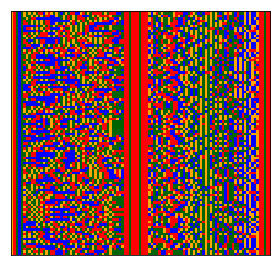

Evaluating on DEN (seq margin 0.5).


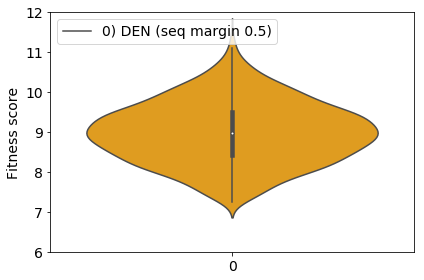

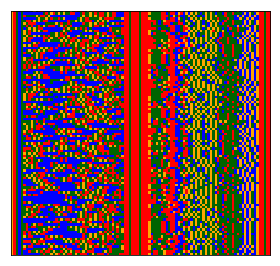

Evaluating on DEN (seq margin 0.3).


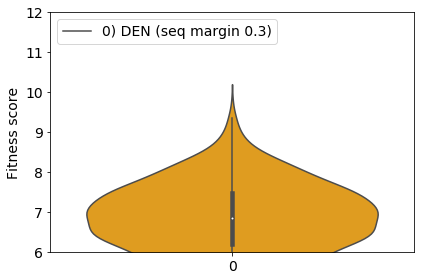

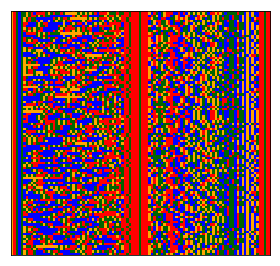

Evaluating on DEN (seq/lat margin 0.5/0.7).


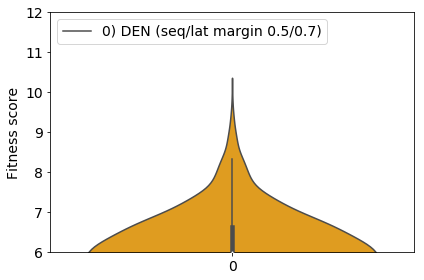

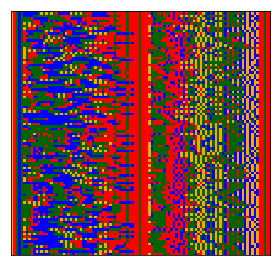

Evaluating on DEN (seq/lat margin 0.3/0.7).


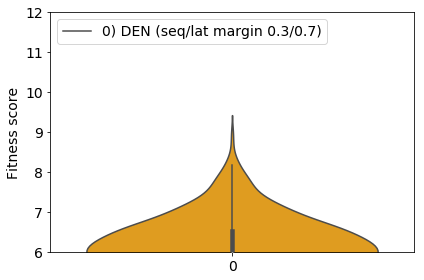

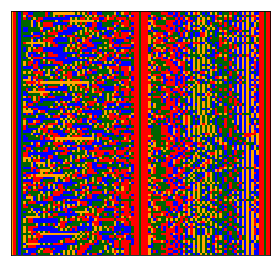

In [20]:
save_figs = True

experiment_suffix = "_individual_den"

model_ixs = [19, 20, 21, 22, 23, 24, 25, 26, 27, 28] + [15, 16, 17, 18]

for temp_ix in model_ixs :

    model_name = model_names[temp_ix]
    model_seqs = model_sequences[temp_ix]
    
    print("Evaluating on " + model_name + ".")
    
    plot_joint_cmp(
        [fitness_scores[temp_ix]],
        [model_names[temp_ix]],
        'Fitness score',
        plot_type='violin',
        colors=['orange'],
        min_y_val=6,
        max_y_val=12,
        figsize=(6, 4),
        save_fig=save_figs,
        fig_name=problem_prefix + experiment_suffix + "_model_" + str(temp_ix) + "_fitness_log_violin",
        legend_outside=False,#True
        violin_bw=0.25
    )

    plot_n_seqs = 100
    plot_start = 70-50
    plot_end = 76+50

    flat_pwms = np.zeros((plot_n_seqs, plot_end - plot_start))
    for i in range(plot_n_seqs) :
        for j in range(0, flat_pwms.shape[1]) :
            max_nt_ix = 0
            if model_seqs[i][j + plot_start] == 'A' :
                max_nt_ix = 0
            elif model_seqs[i][j + plot_start] == 'C' :
                max_nt_ix = 1
            elif model_seqs[i][j + plot_start] == 'G' :
                max_nt_ix = 2
            elif model_seqs[i][j + plot_start] == 'T' :
                max_nt_ix = 3

            flat_pwms[i, j] = max_nt_ix + 1

    cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
    bounds=[0, 1, 2, 3, 4, 5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    f = plt.figure(figsize=(4, 12))

    plt.imshow(flat_pwms, aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()

    if save_figs :
        plt.savefig(problem_prefix + experiment_suffix + "_model_" + str(temp_ix) + "_diversity_seqs.png", transparent=True, dpi=150)
        plt.savefig(problem_prefix + experiment_suffix + "_model_" + str(temp_ix) + "_diversity_seqs.svg")
        plt.savefig(problem_prefix + experiment_suffix + "_model_" + str(temp_ix) + "_diversity_seqs.eps")

    plt.show()

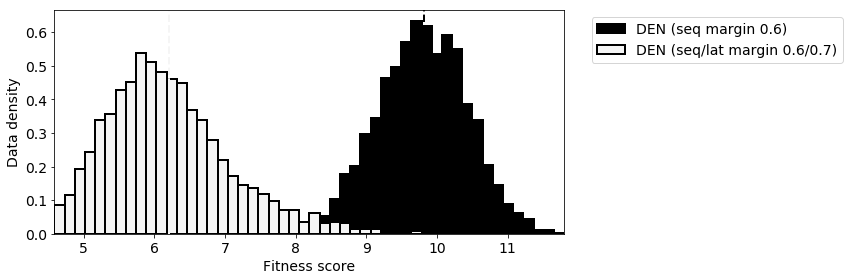

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


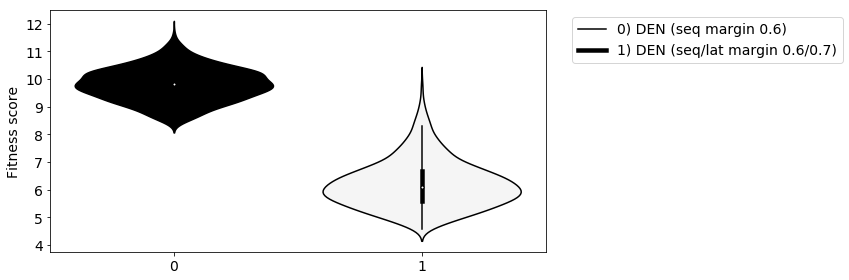

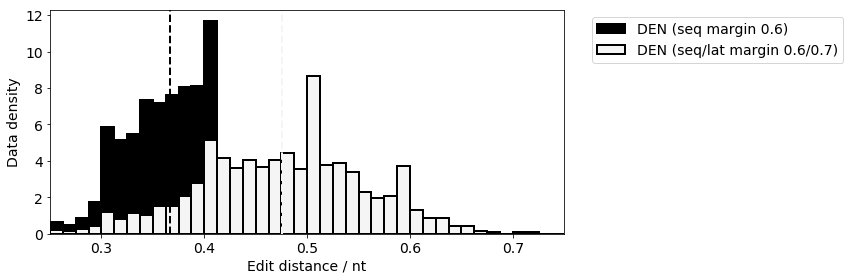

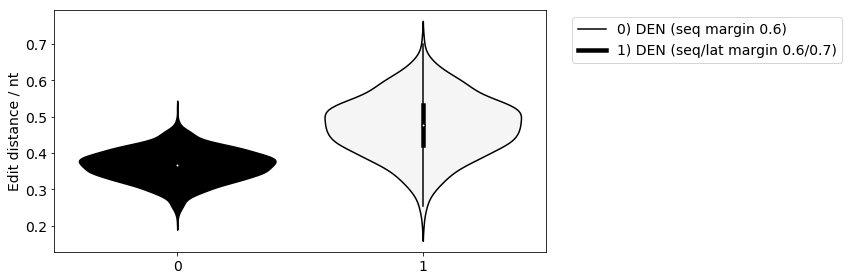

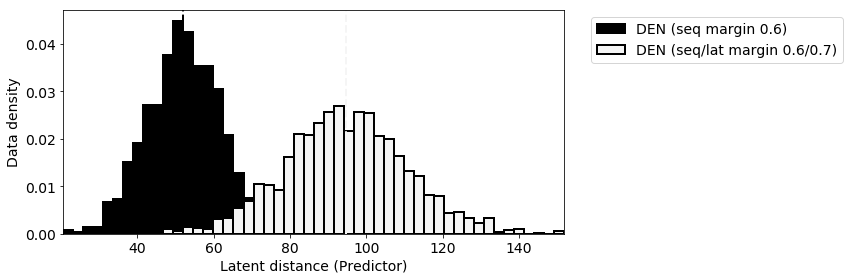

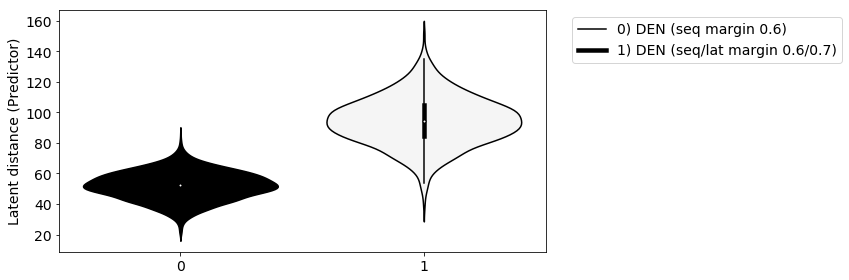

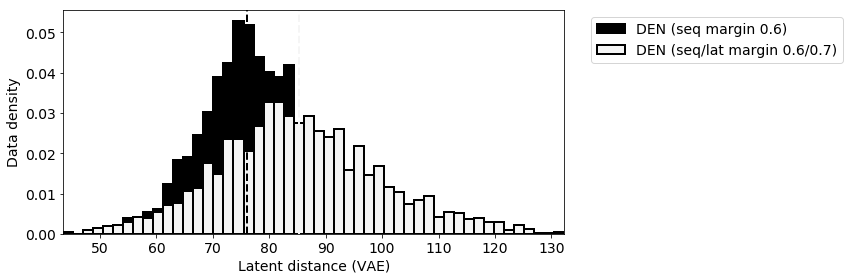

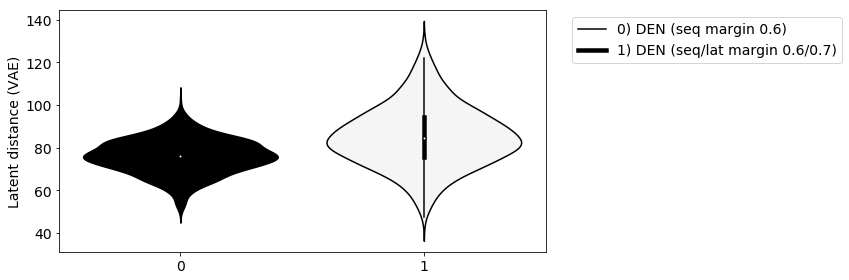

In [12]:
#DEN analysis and comparisons

experiment_suffix = "_den_latent_penalty_comparisons_kl_loss_medium_high_kl_margin_06"

model_ixs = [29, 30]

model_colors = ['dimgrey', 'whitesmoke', 'black'][::-1]

violin_bw = 0.25

plot_joint_histo(
    subselect_list(fitness_scores, model_ixs),
    subselect_list(model_names, model_ixs),
    'Fitness score',
    'Data density',
    colors=model_colors,
    #min_val=-95,
    #max_val=-70,
    #max_y_val = 0.35,
    n_bins=50,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_histo",
    legend_outside=True
)
plot_joint_cmp(
    subselect_list(fitness_scores, model_ixs),
    subselect_list(model_names, model_ixs),
    'Fitness score',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_violin",
    legend_outside=True,
    violin_bw=violin_bw
)

plot_joint_histo(
    subselect_list(edit_distances, model_ixs),
    subselect_list(model_names, model_ixs),
    'Edit distance / nt',
    'Data density',
    colors=model_colors,
    min_val=0.25,
    max_val=0.75,
    #max_y_val = 0.35,
    n_bins=40,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_edit_distance_histo",
    legend_outside=True
)
plot_joint_cmp(
    subselect_list(edit_distances, model_ixs),
    subselect_list(model_names, model_ixs),
    'Edit distance / nt',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_edit_distance_violin",
    legend_outside=True,
    violin_bw=violin_bw
)

plot_joint_histo(
    subselect_list(dense_distances, model_ixs),
    subselect_list(model_names, model_ixs),
    'Latent distance (Predictor)',
    'Data density',
    colors=model_colors,
    #min_val=-95,
    #max_val=-70,
    #max_y_val = 0.35,
    n_bins=50,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_dense_distance_histo",
    legend_outside=True
)
plot_joint_cmp(
    subselect_list(dense_distances, model_ixs),
    subselect_list(model_names, model_ixs),
    'Latent distance (Predictor)',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_dense_distance_violin",
    legend_outside=True,
    violin_bw=violin_bw
)

plot_joint_histo(
    subselect_list(vae_z_distances, model_ixs),
    subselect_list(model_names, model_ixs),
    'Latent distance (VAE)',
    'Data density',
    colors=model_colors,
    #min_val=-95,
    #max_val=-70,
    #max_y_val = 0.35,
    n_bins=50,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_vae_distance_histo",
    legend_outside=True
)
plot_joint_cmp(
    subselect_list(vae_z_distances, model_ixs),
    subselect_list(model_names, model_ixs),
    'Latent distance (VAE)',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_vae_distance_violin",
    legend_outside=True,
    violin_bw=violin_bw
)
